Project Purpose: 使用 segformer 進行 segmentation task

* 因為有 image 跟 mask，所以我用 Segfromer 模型進行 Image segmentation 的測試，網路上有怎麼 finetune 的教學，我有拿來參考。  

[ref](https://github.com/roboflow/notebooks?tab=readme-ov-file)  
[finetune example from colab](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-segformer-segmentation-on-custom-data.ipynb#scrollTo=22a98726)  
[finetune example from colab - 2](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb)  
[dataset training consideration from kaggle](https://www.kaggle.com/code/tanakritduangpet/car-damage-model)

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
humansintheloop_car_parts_and_car_damages_path = kagglehub.dataset_download('humansintheloop/car-parts-and-car-damages')

print('Data source import complete.')

Data source import complete.


Install depencies

In [2]:
!pip install -q transformers==4.46.2 datasets==2.21.0
!pip install -q evaluate

In [3]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

By scan meta.json to get id2label

In [5]:
import json

file_path = r"/kaggle/input/car-parts-and-car-damages/Car damages dataset/meta.json"

# 載入 meta.json
with open(file_path, 'r') as f:
    meta = json.load(f)

# 建立對應表
classes = meta["classes"]
id2label = {i: cls["title"] for i, cls in enumerate(classes)}
label2id = {v: k for k, v in id2label.items()}

print("id2label =", id2label)
print("label2id =", label2id)

id2label = {0: 'Quarter-panel', 1: 'Front-wheel', 2: 'Back-window', 3: 'Trunk', 4: 'Front-door', 5: 'Rocker-panel', 6: 'Grille', 7: 'Windshield', 8: 'Front-window', 9: 'Back-door', 10: 'Headlight', 11: 'Back-wheel', 12: 'Back-windshield', 13: 'Hood', 14: 'Fender', 15: 'Tail-light', 16: 'License-plate', 17: 'Front-bumper', 18: 'Back-bumper', 19: 'Mirror', 20: 'Roof'}
label2id = {'Quarter-panel': 0, 'Front-wheel': 1, 'Back-window': 2, 'Trunk': 3, 'Front-door': 4, 'Rocker-panel': 5, 'Grille': 6, 'Windshield': 7, 'Front-window': 8, 'Back-door': 9, 'Headlight': 10, 'Back-wheel': 11, 'Back-windshield': 12, 'Hood': 13, 'Fender': 14, 'Tail-light': 15, 'License-plate': 16, 'Front-bumper': 17, 'Back-bumper': 18, 'Mirror': 19, 'Roof': 20}


* 需要得到 mask，但送進去 segformer 訓練之前，mask 最好是 binary + 用 id 標示愈分割的類別。

In [18]:
from PIL import Image, ImageDraw

# read files
img_dir = r"/kaggle/input/car-parts-and-car-damages/Car damages dataset/File1/img"
images = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]


ann_dir = r"/kaggle/input/car-parts-and-car-damages/Car damages dataset/File1/ann"

# create output directory
output_img_dir = r"/content/masks_label"
os.makedirs(output_img_dir, exist_ok=True)

def polygon_to_mask(exterior_points, image_size):
    mask = Image.new("L", image_size, 0)
    ImageDraw.Draw(mask).polygon(exterior_points, outline=1, fill=1)
    return np.array(mask)

for img_file in tqdm(images):
    # 知道圖片大小
    img_path = os.path.join(img_dir, img_file)
    img = Image.open(img_path)
    width, height = img.size

    # 建立空白 mask（背景為 0）
    full_mask = np.ones((height, width), dtype=np.uint8) * 255

    ann_file = os.path.join(ann_dir, img_file + ".json")
    if not os.path.exists(ann_file):
        continue

    with open(ann_file) as f:
        annotation = json.load(f)

    for obj in annotation["objects"]:
        class_name = obj["classTitle"]
        class_id = label2id[class_name] # from known information

        polygon = obj["points"]["exterior"]
        polygon = [(x, y) for x, y in polygon]
        object_mask = polygon_to_mask(polygon, (width, height))

        # 將該區域設為對應類別 id（不會蓋掉已有的物件）
        full_mask[object_mask == 1] = class_id

    # 儲存 mask 為 PNG（uint8，每個像素就是 class_id）
    mask_file = os.path.splitext(img_file)[0] + ".png"
    Image.fromarray(full_mask).save(os.path.join(output_img_dir, mask_file))

  0%|          | 0/998 [00:00<?, ?it/s]

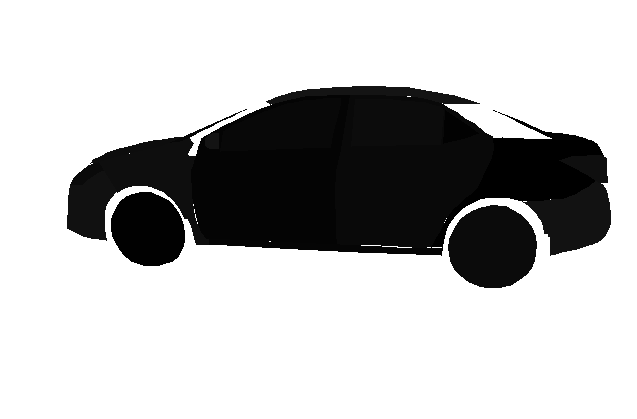

In [8]:
mask_path = "/content/masks_label/Car damages 100.png"
img = Image.open(mask_path)
img

In [9]:
IMAGE_SIZE = 512

import numpy as np
from PIL import Image, ImageDraw

# match each image to corresponding mask
class SemanticSegmentationDatasetv1(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations(masks).
            feature_extractor: Huggingface SegFormerFeatureExtractor
        """
        self.root_dir = root_dir
        self.image_processor = feature_extractor

        # combine next-level directory
        self.img_dir = os.path.join(self.root_dir, "img")
        # self.mask_dir = os.path.join(self.root_dir, "masks_machine")
        self.mask_dir = r"/content/masks_label"
        self.ann_dir = os.path.join(self.root_dir, "ann")
        # self.label_dir = os.path.join(self.root_dir, "labels")

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read mask
        mask_file_names = []
        for root, dirs, files in os.walk(self.mask_dir):
          mask_file_names.extend(files)
        self.masks = sorted(mask_file_names)

        # read annotation
        annotation_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_names.extend(files)
        self.annotations = sorted(annotation_names)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx])).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE), resample=Image.NEAREST)  # images
        # print(np.array(image).shape)
        # 只能讀 binary mask 沒錯
        raw_mask = Image.open(os.path.join(self.mask_dir, self.masks[idx])).convert("L") # segmentation
        mask = raw_mask.resize((IMAGE_SIZE, IMAGE_SIZE), resample=Image.NEAREST)

        # print(np.array(mask).shape)

        # randomly crop + pad both image and segmentation map to same size
        # 重點是送入這裡
        encoded_inputs = self.image_processor(images=np.array(image), segmentation_maps=np.array(mask), return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [19]:
from transformers import SegformerImageProcessor
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

root_dir = r'/kaggle/input/car-parts-and-car-damages/Car damages dataset/File1'
image_processor = SegformerImageProcessor(reduce_labels=False)

dataset = SemanticSegmentationDatasetv1(root_dir, image_processor)

# wrap to dataloader
batch_size = 4
num_workers = 2

# apply train_test_split
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("Number of training examples:", len(train_dataset))
print("Number of testing examples:", len(test_dataset))

Number of training examples: 798
Number of testing examples: 200


Examine the image and corresponding mask

(512, 512)


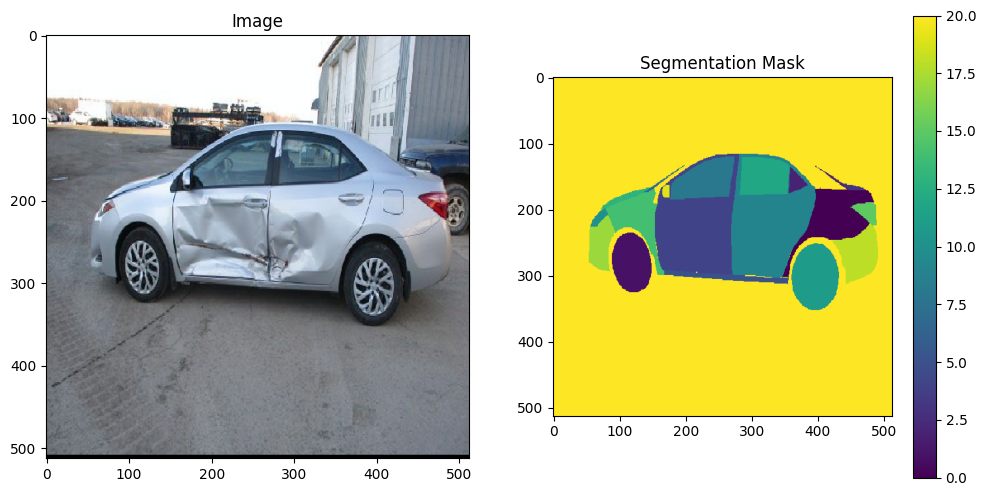

Mask shape: torch.Size([512, 512])
Unique values in mask: tensor([  0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  17,  18,  19,  20, 255])
 → 類別 0（Quarter-panel）：像素數 = 6267
 → 類別 1（Front-wheel）：像素數 = 4263
 → 類別 2（Back-window）：像素數 = 750
 → 類別 3（Trunk）：像素數 = 189
 → 類別 4（Front-door）：像素數 = 13832
 → 類別 5（Rocker-panel）：像素數 = 1524
 → 類別 7（Windshield）：像素數 = 181
 → 類別 8（Front-window）：像素數 = 4505
 → 類別 9（Back-door）：像素數 = 14200
 → 類別 10（Headlight）：像素數 = 347
 → 類別 11（Back-wheel）：像素數 = 5680
 → 類別 12（Back-windshield）：像素數 = 3883
 → 類別 13（Hood）：像素數 = 556
 → 類別 14（Fender）：像素數 = 4123
 → 類別 15（Tail-light）：像素數 = 801
 → 類別 17（Front-bumper）：像素數 = 2253
 → 類別 18（Back-bumper）：像素數 = 3688
 → 類別 19（Mirror）：像素數 = 189
 → 類別 20（Roof）：像素數 = 1601
 → 類別 255（未知）：像素數 = 193312


In [11]:
sample = dataset[0]
image = sample['pixel_values'].permute(1, 2, 0).numpy()  # 如果你做了 transform，會是 tensor
mask = sample['labels']

# 若 mask 是 tensor，轉 numpy
mask_np = mask.cpu().numpy()
print(mask_np.shape)

# 顯示圖像和 mask
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
image_denormalized = (image * std + mean) * 255  # 還原到原本 RGB
image_denormalized = np.clip(image_denormalized, 0, 255).astype(np.uint8)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_denormalized)
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_np, vmin=0, vmax=len(id2label)-1)
plt.title("Segmentation Mask")
plt.colorbar()
plt.show()

print("Mask shape:", mask.shape)
print("Unique values in mask:", torch.unique(mask))
for cid in torch.unique(mask):
    print(f" → 類別 {cid.item()}（{id2label.get(cid.item(), '未知')}）：像素數 = {(mask == cid).sum().item()}")


define model

In [12]:
from transformers import SegformerForSemanticSegmentation

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                              num_labels=len(id2label),
                              id2label=id2label,
                              label2id=label2id,
                            )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.lin

Finetune  
* 因為 segformer 是透過 ADE20k 進行預訓練的，所以有些label他沒看過有機會亂猜，因此需要finetune適合這個資料的模型。

finetune a model with pytorch way

In [13]:
import evaluate

metric = evaluate.load("mean_iou")

In [ ]:
# for cuda debug
!export CUDA_LAUNCH_BLOCKING=1

In [20]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# define epochs
epochs = 30

all_epoch_loss = []
all_epoch_mean_iou = []
all_epoch_mean_accuracy = []

best_iou = 0.0  # 初始化最佳IoU
best_model_path = "best_model.pth"

model.train()
for epoch in range(epochs):  # loop over the dataset multiple times
  print("Epoch:", epoch)
  epoch_loss_total = 0
  batch_count = 0

  for idx, batch in enumerate(tqdm(train_dataloader)):
    # get the inputs;
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(pixel_values=pixel_values, labels=labels)
    loss, logits = outputs.loss, outputs.logits # 計算出的loss 跟 預測的標籤

    loss.backward()
    optimizer.step()

    # evaluate
    with torch.no_grad():
      # 避免跟 output 輸出形狀不同
      upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
      # 得出最有可能的預測標籤
      predicted = upsampled_logits.argmax(dim=1)

      # note that the metric expects predictions + labels as numpy arrays
      metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

    # 累加loss
    epoch_loss_total += loss.item()
    batch_count += 1

  # 一個 epoch 完成後，計算整體 metrics
  metrics = metric.compute(
      num_labels=len(id2label),
      ignore_index=255,
      reduce_labels=False,
  )

  avg_loss = epoch_loss_total / batch_count
  all_epoch_loss.append(avg_loss)
  all_epoch_mean_iou.append(metrics["mean_iou"])
  all_epoch_mean_accuracy.append(metrics["mean_accuracy"])

  print(f"[Epoch {epoch}] Loss: {avg_loss:.4f} | Mean IoU: {metrics['mean_iou']:.4f} | Accuracy: {metrics['mean_accuracy']:.4f}")

  # 如果目前 IoU 更好，就存下這個模型
  if metrics["mean_iou"] >= best_iou:
      best_iou = metrics["mean_iou"]
      torch.save(model.state_dict(), best_model_path)
      print(f"✅ Saved new best model (IoU: {best_iou:.4f})")

Epoch: 0


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


[Epoch 0] Loss: 1.9167 | Mean IoU: 0.1783 | Accuracy: 0.2841
✅ Saved new best model (IoU: 0.1783)
Epoch: 1


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 1] Loss: 1.1063 | Mean IoU: 0.3867 | Accuracy: 0.4991
✅ Saved new best model (IoU: 0.3867)
Epoch: 2


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 2] Loss: 0.8323 | Mean IoU: 0.4909 | Accuracy: 0.6052
✅ Saved new best model (IoU: 0.4909)
Epoch: 3


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 3] Loss: 0.6978 | Mean IoU: 0.5314 | Accuracy: 0.6438
✅ Saved new best model (IoU: 0.5314)
Epoch: 4


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 4] Loss: 0.5844 | Mean IoU: 0.5721 | Accuracy: 0.6773
✅ Saved new best model (IoU: 0.5721)
Epoch: 5


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 5] Loss: 0.5143 | Mean IoU: 0.5966 | Accuracy: 0.6981
✅ Saved new best model (IoU: 0.5966)
Epoch: 6


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 6] Loss: 0.4658 | Mean IoU: 0.6182 | Accuracy: 0.7163
✅ Saved new best model (IoU: 0.6182)
Epoch: 7


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 7] Loss: 0.4187 | Mean IoU: 0.6398 | Accuracy: 0.7328
✅ Saved new best model (IoU: 0.6398)
Epoch: 8


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 8] Loss: 0.3808 | Mean IoU: 0.6590 | Accuracy: 0.7486
✅ Saved new best model (IoU: 0.6590)
Epoch: 9


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 9] Loss: 0.3636 | Mean IoU: 0.6687 | Accuracy: 0.7558
✅ Saved new best model (IoU: 0.6687)
Epoch: 10


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 10] Loss: 0.3279 | Mean IoU: 0.6944 | Accuracy: 0.7787
✅ Saved new best model (IoU: 0.6944)
Epoch: 11


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 11] Loss: 0.2953 | Mean IoU: 0.7169 | Accuracy: 0.7959
✅ Saved new best model (IoU: 0.7169)
Epoch: 12


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 12] Loss: 0.2965 | Mean IoU: 0.7172 | Accuracy: 0.7977
✅ Saved new best model (IoU: 0.7172)
Epoch: 13


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 13] Loss: 0.2810 | Mean IoU: 0.7338 | Accuracy: 0.8121
✅ Saved new best model (IoU: 0.7338)
Epoch: 14


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 14] Loss: 0.2687 | Mean IoU: 0.7460 | Accuracy: 0.8249
✅ Saved new best model (IoU: 0.7460)
Epoch: 15


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 15] Loss: 0.2602 | Mean IoU: 0.7507 | Accuracy: 0.8271
✅ Saved new best model (IoU: 0.7507)
Epoch: 16


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 16] Loss: 0.2391 | Mean IoU: 0.7673 | Accuracy: 0.8411
✅ Saved new best model (IoU: 0.7673)
Epoch: 17


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 17] Loss: 0.2370 | Mean IoU: 0.7693 | Accuracy: 0.8451
✅ Saved new best model (IoU: 0.7693)
Epoch: 18


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 18] Loss: 0.2353 | Mean IoU: 0.7716 | Accuracy: 0.8469
✅ Saved new best model (IoU: 0.7716)
Epoch: 19


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 19] Loss: 0.2129 | Mean IoU: 0.7879 | Accuracy: 0.8571
✅ Saved new best model (IoU: 0.7879)
Epoch: 20


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 20] Loss: 0.2035 | Mean IoU: 0.7971 | Accuracy: 0.8669
✅ Saved new best model (IoU: 0.7971)
Epoch: 21


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 21] Loss: 0.1996 | Mean IoU: 0.8015 | Accuracy: 0.8706
✅ Saved new best model (IoU: 0.8015)
Epoch: 22


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 22] Loss: 0.1892 | Mean IoU: 0.8062 | Accuracy: 0.8733
✅ Saved new best model (IoU: 0.8062)
Epoch: 23


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 23] Loss: 0.1924 | Mean IoU: 0.8103 | Accuracy: 0.8773
✅ Saved new best model (IoU: 0.8103)
Epoch: 24


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 24] Loss: 0.1911 | Mean IoU: 0.8118 | Accuracy: 0.8802
✅ Saved new best model (IoU: 0.8118)
Epoch: 25


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 25] Loss: 0.1766 | Mean IoU: 0.8201 | Accuracy: 0.8840
✅ Saved new best model (IoU: 0.8201)
Epoch: 26


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 26] Loss: 0.1684 | Mean IoU: 0.8272 | Accuracy: 0.8900
✅ Saved new best model (IoU: 0.8272)
Epoch: 27


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 27] Loss: 0.1626 | Mean IoU: 0.8332 | Accuracy: 0.8955
✅ Saved new best model (IoU: 0.8332)
Epoch: 28


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 28] Loss: 0.1553 | Mean IoU: 0.8401 | Accuracy: 0.8995
✅ Saved new best model (IoU: 0.8401)
Epoch: 29


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 29] Loss: 0.1491 | Mean IoU: 0.8446 | Accuracy: 0.9032
✅ Saved new best model (IoU: 0.8446)


Visualize the train loss

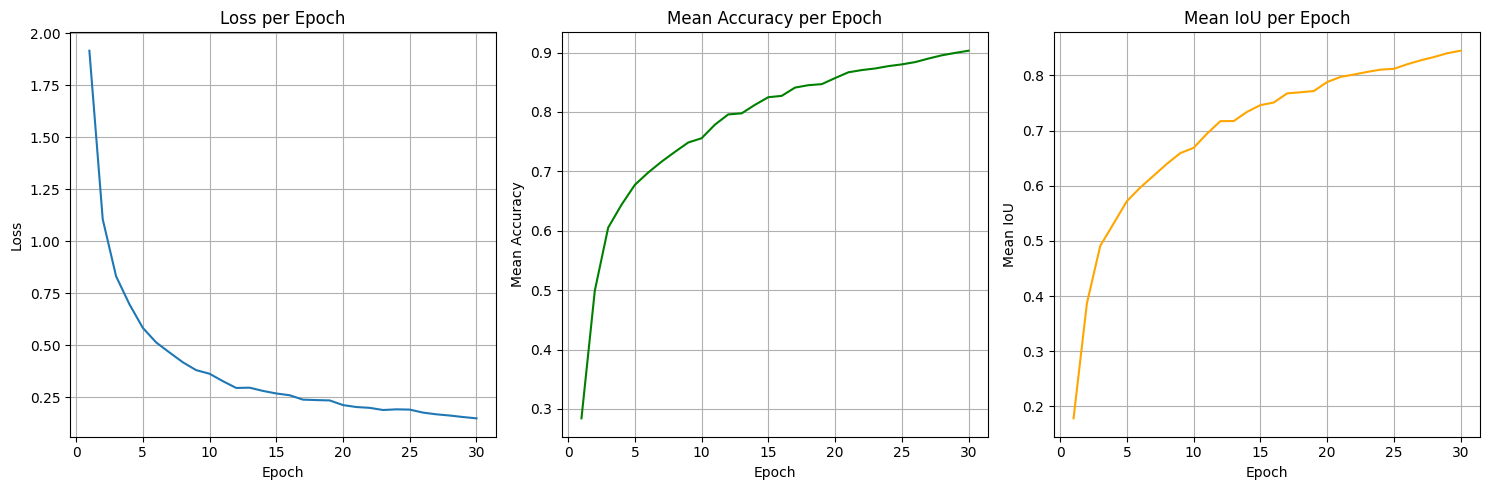

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(all_epoch_loss) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, all_epoch_loss, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, all_epoch_mean_accuracy, label='Mean Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy per Epoch')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, all_epoch_mean_iou, label='Mean IoU', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.title('Mean IoU per Epoch')
plt.grid(True)

plt.tight_layout()
plt.show()


inference

In [22]:
def palette():
    """obstacle palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3]
            ]

Following are 3 examples.

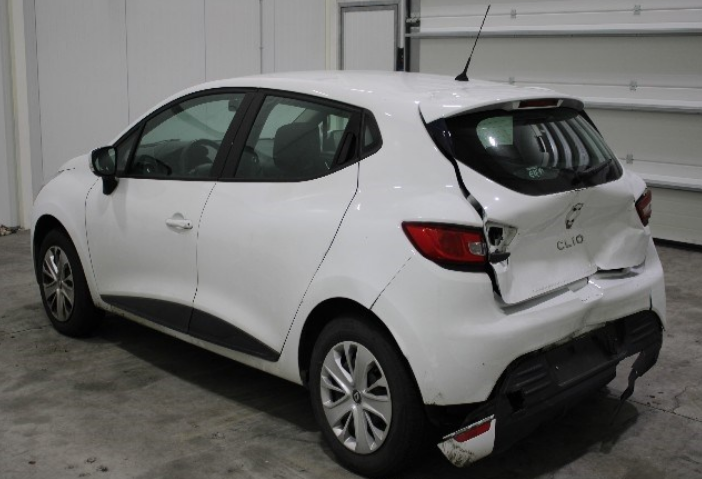

In [27]:
image = Image.open('/kaggle/input/car-parts-and-car-damages/Car damages dataset/File1/img/Car damages 1037.png').convert("RGB")
image

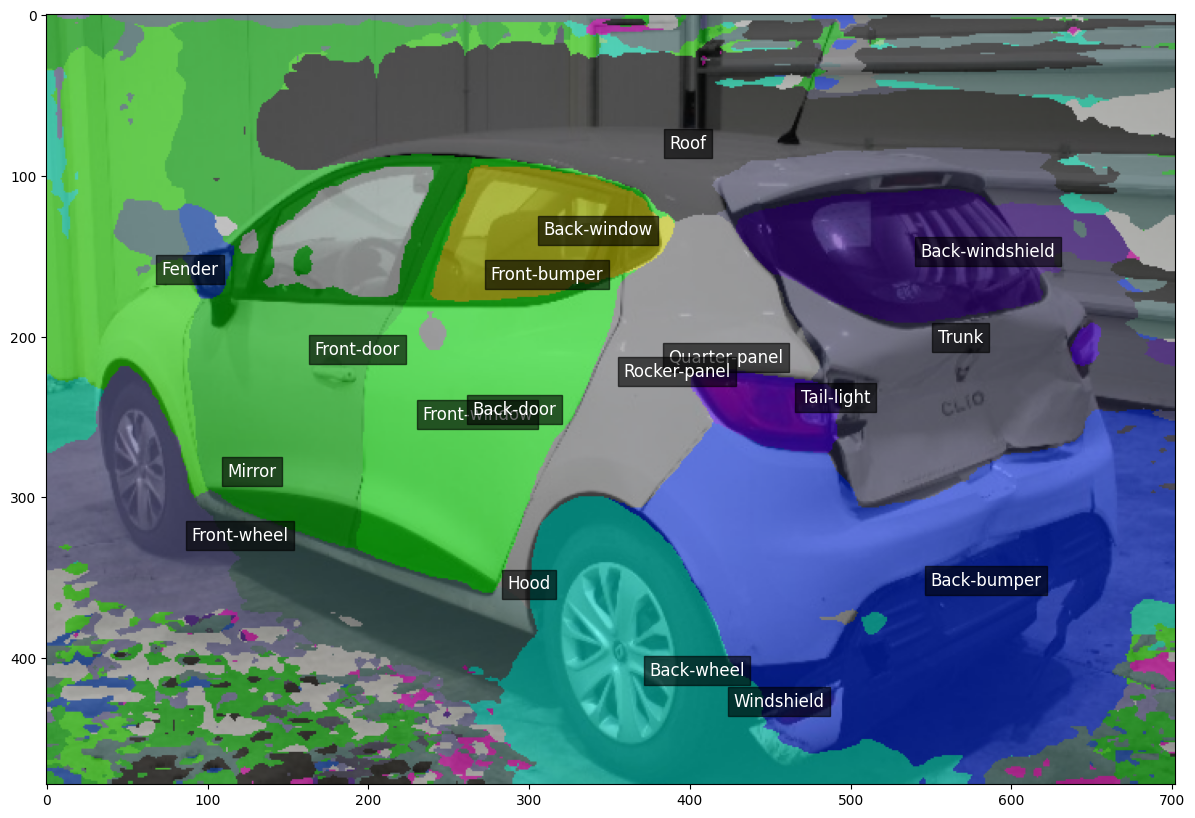

In [28]:
# 類別中心點標註（剛剛說的 center_of_mass）
from scipy.ndimage import center_of_mass

# load the model
model.load_state_dict(torch.load(best_model_path))
model.eval()

# load the image processor
image_processor = SegformerImageProcessor(reduce_labels=False)

# prepare the image for the model
pixel_values = image_processor(np.array(image), return_tensors="pt").pixel_values.to(device)

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

# 找尋最有可能的 output
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

# 空白調色盤
color_seg = np.zeros((predicted_segmentation_map.shape[0],
                  predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

# 取得調色盤
palette = np.array(palette())

for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)

# 加入 label 資訊
unique_classes = np.unique(predicted_segmentation_map)  # 統計出現過的標籤
for cls_id in unique_classes:
    if cls_id == 255: continue  # 無效
    mask = (predicted_segmentation_map == cls_id).astype(np.uint8)
    if mask.sum() == 0 or mask.sum() <= 512:
        continue
    y, x = center_of_mass(mask) # 計算質心
    cls_name = model.config.id2label.get(cls_id, str(cls_id))   # 將類別 id 轉換為類別名稱
    plt.text(x, y, cls_name, fontsize=12, color='white',
              bbox=dict(facecolor='black', alpha=0.6))
plt.axis('off')
plt.show()


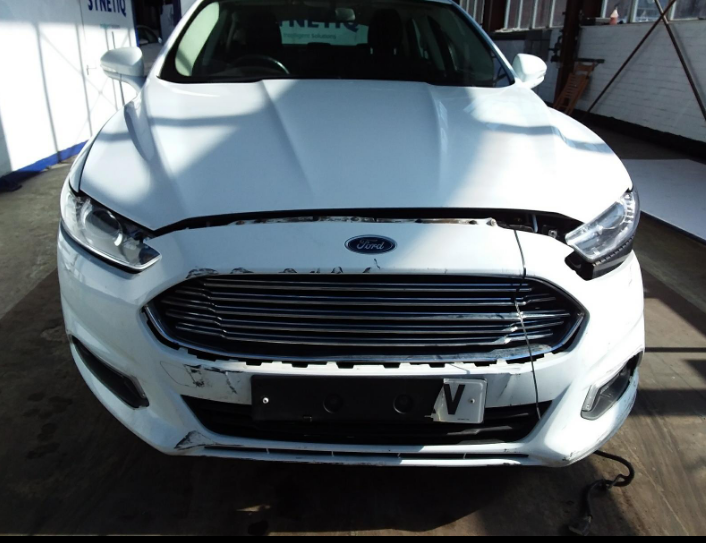

In [30]:
image = Image.open('/kaggle/input/car-parts-and-car-damages/Car damages dataset/File1/img/Car damages 1058.png').convert("RGB")
image

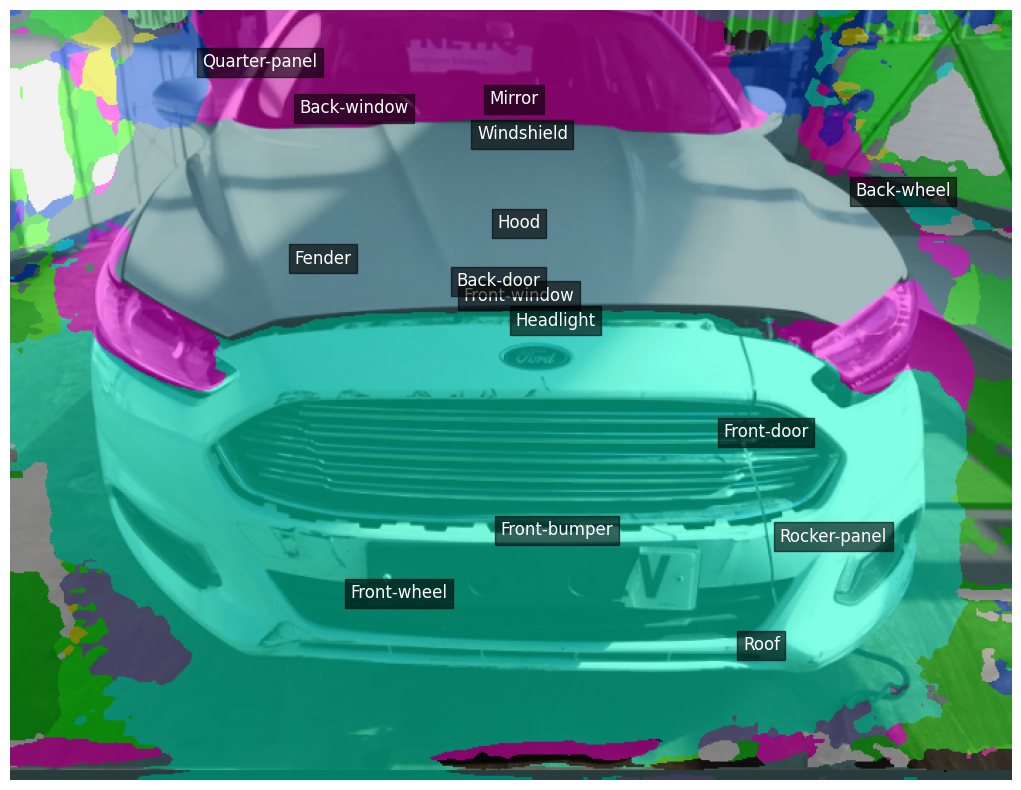

In [31]:
# 類別中心點標註（剛剛說的 center_of_mass）
from scipy.ndimage import center_of_mass

# load the model
model.load_state_dict(torch.load(best_model_path))
model.eval()

# load the image processor
image_processor = SegformerImageProcessor(reduce_labels=False)

# prepare the image for the model
pixel_values = image_processor(np.array(image), return_tensors="pt").pixel_values.to(device)

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

# 找尋最有可能的 output
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

# 空白調色盤
color_seg = np.zeros((predicted_segmentation_map.shape[0],
                  predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

# 取得調色盤
# palette = np.array(palette())

for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)

# 加入 label 資訊
unique_classes = np.unique(predicted_segmentation_map)  # 統計出現過的標籤
for cls_id in unique_classes:
    if cls_id == 255: continue  # 無效
    mask = (predicted_segmentation_map == cls_id).astype(np.uint8)
    if mask.sum() == 0 or mask.sum() <= 512:
        continue
    y, x = center_of_mass(mask) # 計算質心
    cls_name = model.config.id2label.get(cls_id, str(cls_id))   # 將類別 id 轉換為類別名稱
    plt.text(x, y, cls_name, fontsize=12, color='white',
              bbox=dict(facecolor='black', alpha=0.6))
plt.axis('off')
plt.show()

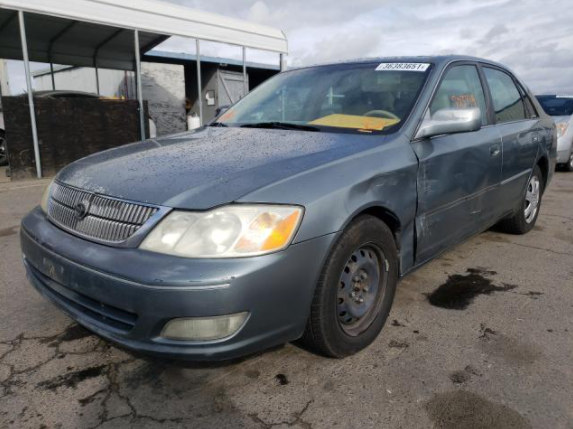

In [32]:
image = Image.open('/kaggle/input/car-parts-and-car-damages/Car damages dataset/File1/img/Car damages 861.png').convert("RGB")
image

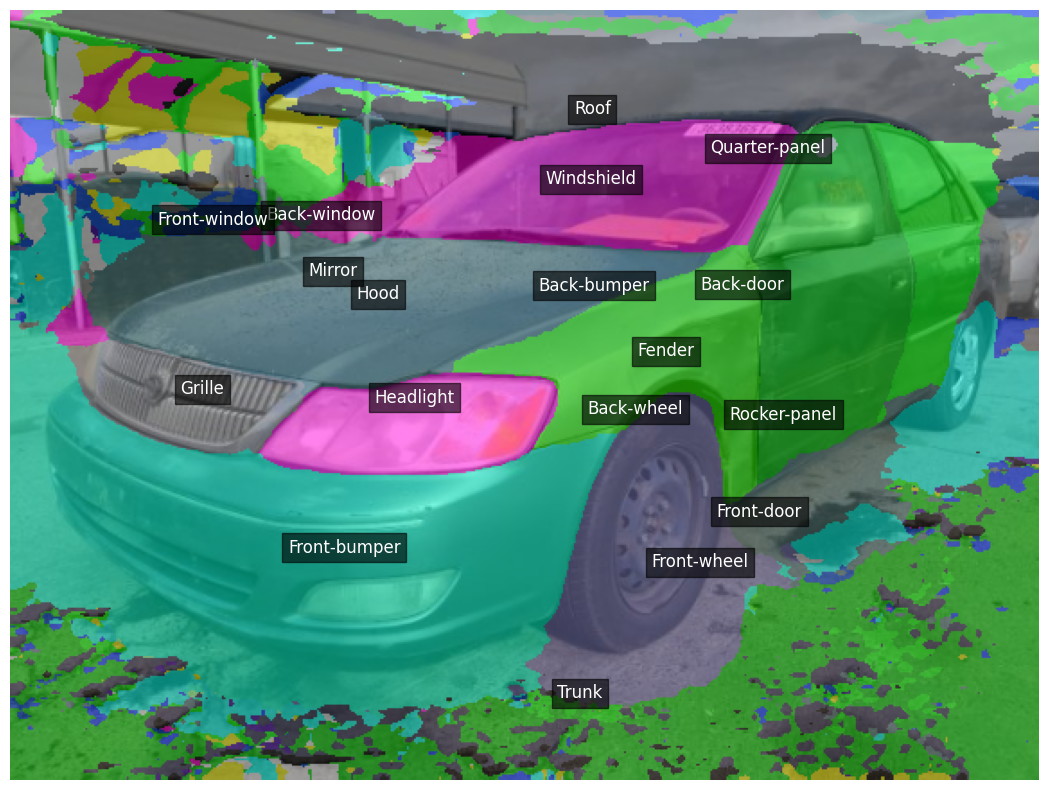

In [33]:
# 類別中心點標註（剛剛說的 center_of_mass）
from scipy.ndimage import center_of_mass

# load the model
model.load_state_dict(torch.load(best_model_path))
model.eval()

# load the image processor
image_processor = SegformerImageProcessor(reduce_labels=False)

# prepare the image for the model
pixel_values = image_processor(np.array(image), return_tensors="pt").pixel_values.to(device)

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

# 找尋最有可能的 output
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

# 空白調色盤
color_seg = np.zeros((predicted_segmentation_map.shape[0],
                  predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

# 取得調色盤
# palette = np.array(palette())

for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)

# 加入 label 資訊
unique_classes = np.unique(predicted_segmentation_map)  # 統計出現過的標籤
for cls_id in unique_classes:
    if cls_id == 255: continue  # 無效
    mask = (predicted_segmentation_map == cls_id).astype(np.uint8)
    if mask.sum() == 0 or mask.sum() <= 512:
        continue
    y, x = center_of_mass(mask) # 計算質心
    cls_name = model.config.id2label.get(cls_id, str(cls_id))   # 將類別 id 轉換為類別名稱
    plt.text(x, y, cls_name, fontsize=12, color='white',
              bbox=dict(facecolor='black', alpha=0.6))
plt.axis('off')
plt.show()

testing

In [29]:
# load the model
model.load_state_dict(torch.load(best_model_path))
model.eval()

# load the image processor
image_processor = SegformerImageProcessor(reduce_labels=False)

for idx, batch in enumerate(tqdm(test_dataloader)):

  # evaluate
  with torch.no_grad():
    # get the inputs;
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)

    # forward + backward + optimize
    outputs = model(pixel_values=pixel_values, labels=labels)
    loss, logits = outputs.loss, outputs.logits # 計算出的loss 跟 預測的標籤

    # 避免跟 output 輸出形狀不同
    upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
    # 得出最有可能的預測標籤
    predicted = upsampled_logits.argmax(dim=1)

    # note that the metric expects predictions + labels as numpy arrays
    metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

    # 累加loss
    epoch_loss_total += loss.item()
    batch_count += 1

# 一個 epoch 完成後，計算整體 metrics
metrics = metric.compute(
    num_labels=len(id2label),
    ignore_index=255,
    reduce_labels=False,
)

avg_loss = epoch_loss_total / batch_count

print(f"Loss: {avg_loss:.4f} | Mean IoU: {metrics['mean_iou']:.4f} | Accuracy: {metrics['mean_accuracy']:.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 0.2206 | Mean IoU: 0.6440 | Accuracy: 0.7579


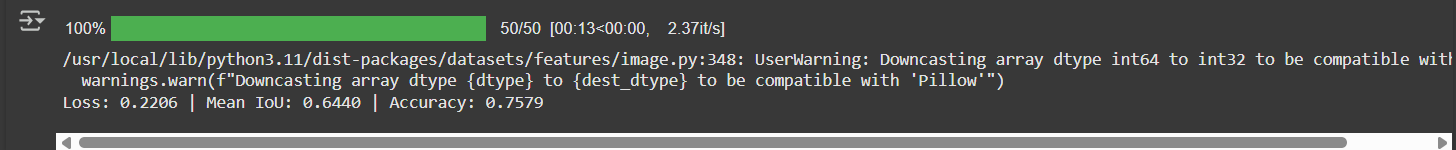

* 我本來要玩玩看辨識損傷的地方，結果我好像拿到"有破損的車，是否還能用 segmentation 分辨零件"
* 但這次結果比之前 LAKE-RED 生成圖片那次還好。
* 雖然感覺還有可進步空間，暫時先這樣。